In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from google.colab import files 
uploaded = files.upload()

Saving JPM.csv to JPM.csv


In [3]:
df = pd.read_csv('JPM.csv')
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,Close_Nor
0,03-01-2017,77.015022,87.230003,87.760002,85.980003,87.339996,20550700,0.132130
1,04-01-2017,77.157074,86.910004,87.180000,86.400002,86.959999,15266600,0.126974
2,05-01-2017,76.446846,86.110001,87.110001,85.260002,86.809998,14300800,0.114083
3,06-01-2017,76.455742,86.120003,86.620003,85.940002,86.389999,12893300,0.114244
4,09-01-2017,76.509003,86.180000,86.769997,85.519997,85.730003,12806600,0.115211


In [4]:
from collections import deque
import random
from tensorflow.python.framework import ops
%tensorflow_version 1.x

rew_lst = []
global rew_lst
name = 'Trader'

class Trader:
    def __init__(self, state_space, duration, increment, batch_size):
        self.state_space = state_space
        self.duration = duration
        self.half_window = duration // 2
        self.increment = increment
        self.action_space = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        ''' 
    Set up reinforcement learning parameters: 
    ------------------------------------------------------------------------------
    param gamma: discount rate 
    param epsilon: to determine whether we should use a random action or to use the model for the action.
    param epsilon_min: minimal value of epsilon
    param epsilon_decay: set the speed of decreasing epsilon
    '''

        self.gamma = 0.95
        self.epsilon = 0.1
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        ops.reset_default_graph()
        self.sess=tf.compat.v1.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_space])
        self.Y = tf.placeholder(tf.float32, [None, self.action_space])
        layer1 = tf.layers.dense(self.X, 64, activation = tf.nn.leaky_relu)
        layer2 = tf.layers.dense(layer1, 32, activation = tf.nn.leaky_relu)
        layer3 = tf.layers.dense(layer2, 8, activation = tf.nn.leaky_relu)
        self.outputs = tf.layers.dense(layer3, self.action_space)
        self.loss = tf.reduce_mean(tf.square(self.Y - self.outputs))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-4).minimize(self.loss)
        self.sess.run(tf.global_variables_initializer())

    
    def get_state(self, t, attr):
        duration = self.duration + 1
        id = t - duration + 1
        block = attr[id : t + 1] if id >= 0 else -id * [attr[0]] + attr[0 : t + 1]
        lst = []
        for i in range(duration - 1):
            lst.append(block[i + 1] - block[i])
        return np.array([lst])
        
    def act(self, state):
        if random.random() <= self.epsilon:
          return random.randrange(self.action_space)
        return np.argmax(self.sess.run(self.outputs, feed_dict = {self.X: state})[0])


    def exp_replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_space))
        Y = np.empty((replay_size, self.action_space))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.outputs, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.outputs, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            goal = Q[i]
            goal[action] = reward
            rew_lst.append(goal[action])
            if not done:
                goal[action] += self.gamma * np.amax(Q_new[i])
                rew_lst.append(goal[action])
            X[i] = state
            Y[i] = goal
        loss, _ = self.sess.run([self.loss, self.optimizer], feed_dict = {self.X: X, self.Y: Y})
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return loss

 
    def trade(self, balance, attr):
        money = balance
        selling_days = [] 
        buying_days = []
        inventory = []
        state = self.get_state(0, attr)
        for t in range(0, len(attr) - 1, self.increment):
            action = self.act(state)
            next_state = self.get_state(t + 1, attr)
            
            if action == 1 and balance >= attr[t] and t < (len(attr) - self.half_window):
                inventory.append(attr[t])
                balance -= attr[t]
                buying_days.append(t)
                print('Day %d: \t Buy at: $ %f \t Balance = $ %f'% (t, attr[t], balance))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                balance += attr[t]
                selling_days.append(t)
                try:
                    ret = ((close[t] - bought_price) / bought_price) * 100
                except:
                    ret = 0
                print('Day %d: \t Sell at: $ %f \t Balance = $ %f,'% (t, attr[t], balance))
            else: 
              continue
            
            state = next_state
        ret = ((balance - money) / money) * 100
        overall = balance - money
        return buying_days, selling_days, overall, ret
        
    def train(self, iterations, checkpoint, balance, attr):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0, attr)
            money = balance
            for t in range(0, len(attr) - 1, self.increment):
                action = self.act(state)
                next_state = self.get_state(t + 1, attr)
                if action==0:
                  continue
                elif action == 1 and money >= attr[t] and t < (len(attr) - self.half_window):
                    inventory.append(attr[t])
                    money -= attr[t] 
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += attr[t] - bought_price
                    money += attr[t]
              
                ret = ((money - balance) / balance)
                self.memory.append((state, action, ret, next_state, money < balance))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                loss = self.exp_replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('Epoch: %d \t Reward: %f \t Balance: %f \t Loss: %f'%(i + 1, total_profit, money, loss))

TensorFlow is already loaded. Please restart the runtime to change versions.


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
close = df.Close_Nor.values.tolist()

In [7]:
train ,test = train_test_split(close ,test_size=0.2) 

In [8]:
len(train), len(test)

(828, 208)

In [9]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

close = df.Close.values.tolist() 

balance = 1000
duration = 30
increment = 1
batch_size = 32

agent = Trader(state_space = duration,  duration = duration,  increment = increment,  batch_size = batch_size)

Instructions for updating:
non-resource variables are not supported in the long term


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [10]:
agent.train(iterations = 300, checkpoint = 50, balance = balance, attr = train)

Epoch: 50 	 Reward: 0.541250 	 Balance: 1000.541250 	 Loss: 0.004874
Epoch: 100 	 Reward: 0.283274 	 Balance: 1000.283274 	 Loss: 0.009506
Epoch: 150 	 Reward: -0.826620 	 Balance: 999.173380 	 Loss: 0.008610
Epoch: 200 	 Reward: 0.094328 	 Balance: 999.535030 	 Loss: 0.006520
Epoch: 250 	 Reward: 0.844344 	 Balance: 1000.844344 	 Loss: 0.004938
Epoch: 300 	 Reward: -0.806800 	 Balance: 999.193200 	 Loss: 0.005401


In [ ]:
buying_days, selling_days, overall, ret = agent.trade(balance = balance, attr = test)

Day 80: 	 Buy at: $ 93.300003 	 Balance = $ 906.699997
Day 82: 	 Sell at: $ 115.410004 	 Balance = $ 1022.110001,


In [ ]:
if overall>0:
  print("Profit = $ ", overall)
else:
  print("Loss = $ ", overall)

Profit = $  22.110000650000075


In [ ]:
print('Return = ', ret, "%")

Return =  2.2110000650000075 %


In [ ]:
len(rew_lst), max(rew_lst), min(rew_lst)

(163626, 9.520548, -5.1324325)

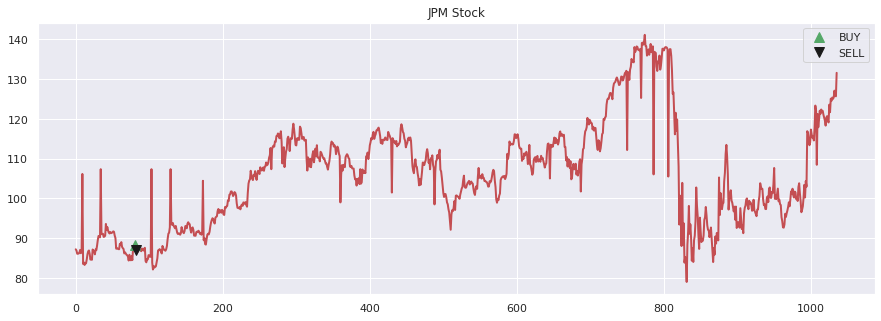

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='g', label = 'BUY', markevery = buying_days)
plt.plot(close, 'v', markersize=10, color='k', label = 'SELL', markevery = selling_days)
plt.title('JPM Stock')
plt.legend()
plt.show()